# Hourly Energy Consumption of Pennsylvania-New Jersey-Maryland Interconnection (PJM) West Region using the ARIMA model

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)

## Data Loading

In [10]:
df = pd.read_csv('data/PJMW_hourly.csv', parse_dates=['Datetime'],
                 index_col='Datetime')
df = df.resample('D').sum()

## Data Exploration

### Time Series Plot

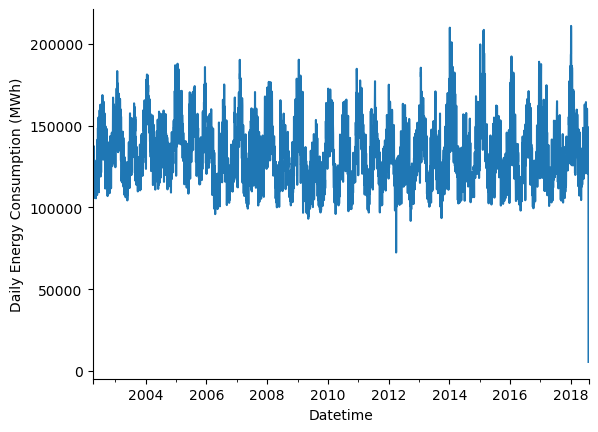

In [15]:
ax = df.PJMW_MW.plot()
ax.set_ylabel('Daily Energy Consumption (MWh)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [17]:
df = df.iloc[:-1]
df

,PJMW_MW
Datetime,
2002-04-01,121237.0
2002-04-02,127450.0
2002-04-03,127822.0
2002-04-04,136099.0
2002-04-05,136467.0
...,...
2018-07-29,127052.0
2018-07-30,131825.0
2018-07-31,135858.0


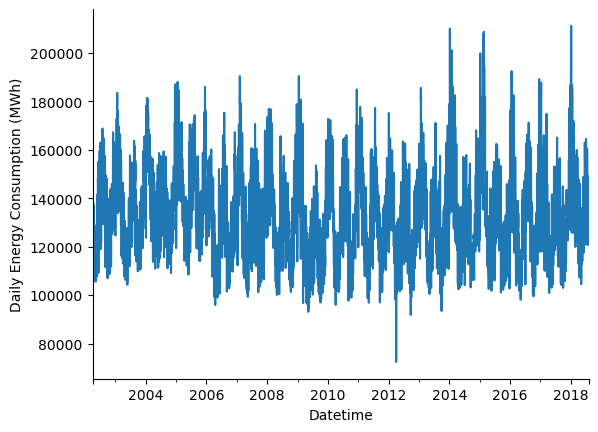

In [19]:
ax = df.PJMW_MW.plot()
ax.set_ylabel('Daily Energy Consumption (MWh)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### Histogram and Density Plot

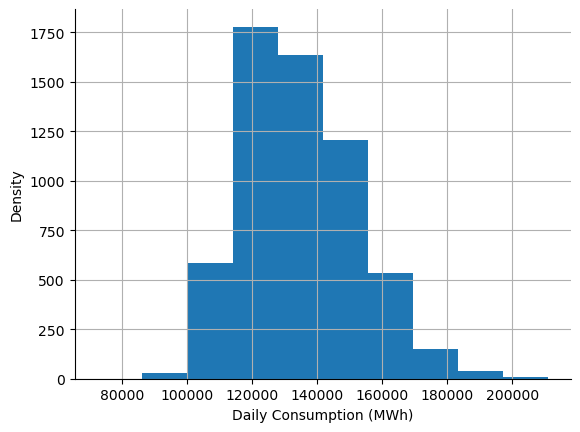

In [20]:
ax = df.PJMW_MW.hist()
ax.set_xlabel('Daily Consumption (MWh)')
ax.set_ylabel('Density')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

/tmp/ipykernel_30581/3683877866.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Year'] = df.index.year


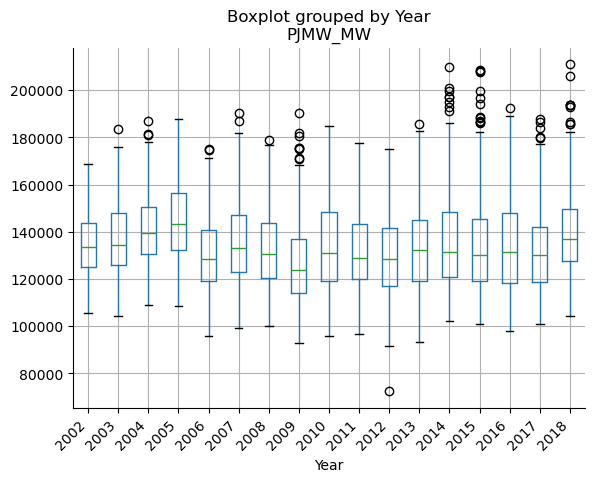

In [24]:
df.loc[:, 'Year'] = df.index.year
ax = df.boxplot(column='PJMW_MW', by='Year')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=45, ha='right');

### Data Quality Check

In [25]:
missval = df.isnull().sum()[0]
missdates = len(df) - len(pd.date_range(df.index[0], df.index[-1], freq='D'))
print(f"Number of missing values: {missval}")
print(f"Number of missing dates: {missdates}")

Number of missing values: 0
Number of missing dates: 0


### ACF and PACF

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

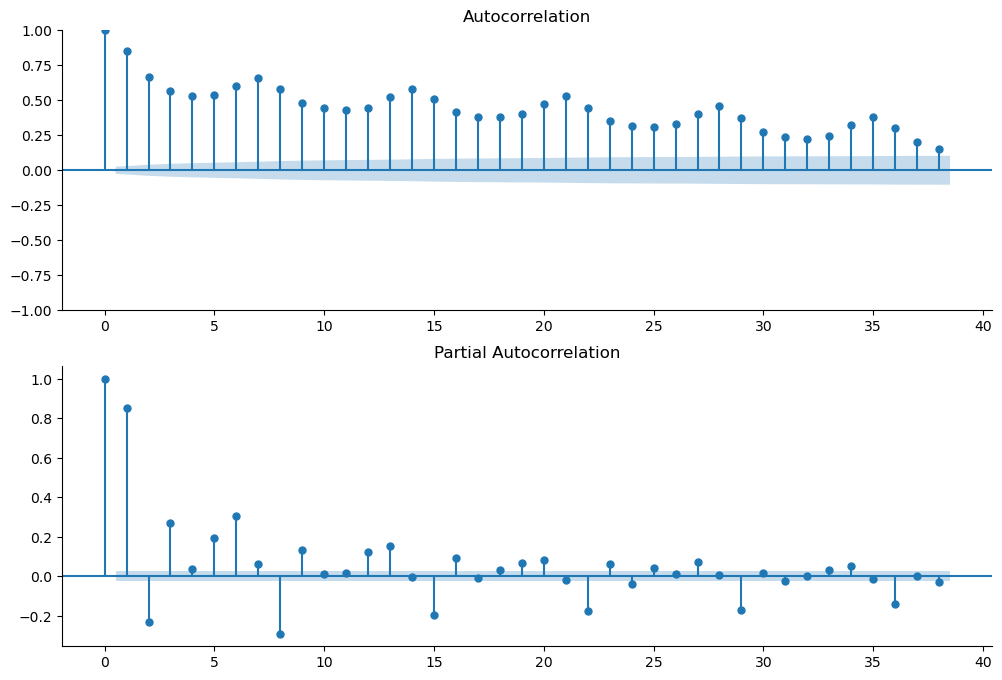

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df.PJMW_MW, ax=ax[0])
plot_pacf(df.PJMW_MW, ax=ax[1])

for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
plt.autoscale()
plt.show()

Possible underlying models:
AR(1), AR(2), AR(6), AR(8), MA(1), MA(7)

### Tests for Stationarity

In [28]:
from statsmodels.tsa.stattools import adfuller

In [29]:
def adf_test(ts):
    """Perform adf test in the given time series ts"""
    res = adfuller(ts)

    print('ADF = %f' % res[0])
    print('p-value = %f' % res[1])
    print('Critical Values:')

    for k, v in res[4].items():
        print('\t%s: %.3f' % (k, v))

    return res

### Original

In [36]:
ts = df.PJMW_MW.copy()
adf_test(ts)

ADF = -7.264578
p-value = 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


(-7.264577955891202,
 1.6477525042615578e-10,
 33,
 5934,
 {'1%': -3.43145248248047,
  '5%': -2.862027194919521,
  '10%': -2.5670293315425985},
 121963.84104826572)

### Differenced

In [31]:
ts_diff = df.PJMW_MW.copy()
ts_diff = ts_diff.diff(7)[7:]

In [34]:
adf_test(ts_diff)

ADF = -13.959515
p-value = 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


(-13.959515466441928,
 4.5467817690251673e-26,
 33,
 5927,
 {'1%': -3.431453785116473,
  '5%': -2.8620277704568604,
  '10%': -2.567029637916796},
 121941.86397595596)

## Data Segregation

In [59]:
trainval, holdout = ts.iloc[:-365], ts.iloc[-365:]
train, val = trainval.iloc[:-365], trainval.iloc[-365:]

## Baselines

In [93]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [94]:
baselines = []
metrics = {'MAE': mean_absolute_error,
           'MSE': mean_squared_error,
           'MAPE': mean_absolute_percentage_error,}
for metric in metrics.values():
    baselines.append({
        'Naive': metric(val.iloc[:-30], val.shift(-30).dropna()),
    })

In [95]:
baselines = pd.DataFrame(baselines, index=metrics.keys())
baselines

,Naive
MAE,1.740159e+04
MSE,4.804893e+08
MAPE,1.298085e-01


In [122]:
baselines.to_csv('results/naive.csv')

## Model Training

### ARIMA

In [70]:
from tqdm import tqdm
from itertools import product
from statsmodels.tsa.arima.model import ARIMA

In [79]:
val.index[:-30]

DatetimeIndex(['2016-08-03', '2016-08-04', '2016-08-05', '2016-08-06',
               '2016-08-07', '2016-08-08', '2016-08-09', '2016-08-10',
               '2016-08-11', '2016-08-12',
               ...
               '2017-06-24', '2017-06-25', '2017-06-26', '2017-06-27',
               '2017-06-28', '2017-06-29', '2017-06-30', '2017-07-01',
               '2017-07-02', '2017-07-03'],
              dtype='datetime64[ns]', name='Datetime', length=335, freq='D')

In [83]:
# Forecasting range
h = 30

# p, d, q ranges
p_range = range(3)
d_range = [0]
q_range = range(3)

model_performances = []
for p, d, q in product(p_range, d_range, q_range):
    y_actuals = []
    y_preds = []

    print(f"Currently training: ARIMA {(p, d, q)}")
    pb = tqdm(total=len(val))
    for i, start_date in enumerate(val.index[:-h]):
        pb.set_description(f"Iter number: {i + 1} of {len(val[:-h])}")
        end_date = start_date + pd.Timedelta('30D')

        # Get actual values
        y_actuals.append(trainval[end_date])

        # Get historical values
        x_train = trainval[:start_date - pd.Timedelta('30D')]

        # Model fitting and forecasting
        model = ARIMA(x_train, order=(p, d, q)).fit()
        y_preds.append(model.forecast(h)[-1])

    # Model performance
    model_performances.append({
        'Estimator': f'ARIMA {(p, d, q)}',
        'MAE': mean_absolute_error(y_actuals, y_preds),
        'MSE': mean_squared_error(y_actuals, y_preds),
        'MAPE': mean_absolute_percentage_error(y_actuals, y_preds),
    })
    print(model_performances[-1])
pd.DataFrame(model_performances).sort_values('MAE')

Currently training: ARIMA (0, 0, 0)


Iter number: 335 of 335:   0%|          | 0/365 [00:31<?, ?it/s]

{'Estimator': 'ARIMA (0, 0, 0)', 'MAE': 14497.98586190823, 'MSE': 301106745.8008939, 'MAPE': 0.11330966580423875}
Currently training: ARIMA (0, 0, 1)



Iter number: 335 of 335:   0%|          | 0/365 [00:31<?, ?it/s]

Iter number: 1 of 335:   0%|          | 0/365 [00:00<?, ?it/s]/home/llorenzo/.conda/envs/msds2024-ml3-a3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

Iter number: 2 of 335:   0%|          | 0/365 [00:00<?, ?it/s]/home/llorenzo/.conda/envs/msds2024-ml3-a3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

Iter number: 3 of 335:   0%|          | 0/365 [00:00<?, ?it/s]/home/llorenzo/.conda/envs/msds2024-ml3-a3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('No

{'Estimator': 'ARIMA (0, 0, 1)', 'MAE': 14497.985861912437, 'MSE': 301106745.80084455, 'MAPE': 0.1133096658041387}
Currently training: ARIMA (0, 0, 2)


Iter number: 335 of 335:   0%|          | 0/365 [02:45<?, ?it/s]

{'Estimator': 'ARIMA (0, 0, 2)', 'MAE': 14497.985861911118, 'MSE': 301106745.80090994, 'MAPE': 0.11330966580420403}
Currently training: ARIMA (1, 0, 0)



Iter number: 335 of 335:   0%|          | 0/365 [02:46<?, ?it/s]

Iter number: 335 of 335:   0%|          | 0/365 [01:02<?, ?it/s]

{'Estimator': 'ARIMA (1, 0, 0)', 'MAE': 14536.88570928712, 'MSE': 302490466.3243908, 'MAPE': 0.1136036063915891}
Currently training: ARIMA (1, 0, 1)


Iter number: 335 of 335:   0%|          | 0/365 [02:04<?, ?it/s]

{'Estimator': 'ARIMA (1, 0, 1)', 'MAE': 14498.722237359269, 'MSE': 301132306.04473114, 'MAPE': 0.11331525472094085}
Currently training: ARIMA (1, 0, 2)



Iter number: 335 of 335:   0%|          | 0/365 [02:04<?, ?it/s]

Iter number: 335 of 335:   0%|          | 0/365 [04:56<?, ?it/s]

{'Estimator': 'ARIMA (1, 0, 2)', 'MAE': 16076.07291139193, 'MSE': 365277476.58056456, 'MAPE': 0.12520658124253034}
Currently training: ARIMA (2, 0, 0)


Iter number: 335 of 335:   0%|          | 0/365 [01:08<?, ?it/s]

{'Estimator': 'ARIMA (2, 0, 0)', 'MAE': 14498.547835933328, 'MSE': 301126357.19081527, 'MAPE': 0.1133139419424539}
Currently training: ARIMA (2, 0, 1)



Iter number: 335 of 335:   0%|          | 0/365 [01:09<?, ?it/s]

Iter number: 1 of 335:   0%|          | 0/365 [00:00<?, ?it/s]/home/llorenzo/.conda/envs/msds2024-ml3-a3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

Iter number: 2 of 335:   0%|          | 0/365 [00:00<?, ?it/s]/home/llorenzo/.conda/envs/msds2024-ml3-a3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

Iter number: 3 of 335:   0%|          | 0/365 [00:01<?, ?it/s]/home/llorenzo/.conda/envs/msds2024-ml3-a3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('No

{'Estimator': 'ARIMA (2, 0, 1)', 'MAE': 14501.962560101669, 'MSE': 301245865.5144073, 'MAPE': 0.11333984625775265}
Currently training: ARIMA (2, 0, 2)


Iter number: 1 of 335:   0%|          | 0/365 [00:00<?, ?it/s]/home/llorenzo/.conda/envs/msds2024-ml3-a3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/llorenzo/.conda/envs/msds2024-ml3-a3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
Iter number: 2 of 335:   0%|          | 0/365 [00:02<?, ?it/s]/home/llorenzo/.conda/envs/msds2024-ml3-a3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/llorenzo/.conda/envs/msds2024-ml3-a3/lib/python

{'Estimator': 'ARIMA (2, 0, 2)', 'MAE': 17678.998335423035, 'MSE': 438520831.65032357, 'MAPE': 0.13733616145387187}


,Estimator,MAE,MSE,MAPE
0,"ARIMA (0, 0, 0)",14497.985862,3.011067e+08,0.113310
2,"ARIMA (0, 0, 2)",14497.985862,3.011067e+08,0.113310
1,"ARIMA (0, 0, 1)",14497.985862,3.011067e+08,0.113310
6,"ARIMA (2, 0, 0)",14498.547836,3.011264e+08,0.113314
4,"ARIMA (1, 0, 1)",14498.722237,3.011323e+08,0.113315
7,"ARIMA (2, 0, 1)",14501.962560,3.012459e+08,0.113340
3,"ARIMA (1, 0, 0)",14536.885709,3.024905e+08,0.113604
5,"ARIMA (1, 0, 2)",16076.072911,3.652775e+08,0.125207
8,"ARIMA (2, 0, 2)",17678.998335,4.385208e+08,0.137336


## Model Finalization

In [102]:
actuals = []
predictions = []

p, d, q = (1, 0, 1)

pb = tqdm(total=len(holdout))
for i, start_date in enumerate(holdout.index[:-h]):
    pb.set_description(f"Iter number: {i + 1} of {len(holdout)}")
    end_date = start_date + pd.Timedelta('30D')

    # Get actual values
    actuals.append(holdout[end_date])

    # Get historical values
    x_train = ts[:start_date - pd.Timedelta('30D')]

    # Model fitting and forecasting
    model = ARIMA(x_train, order=(p, d, q)).fit()
    predictions.append(model.forecast(h)[-1])

    pb.update(1)

predictions = pd.DataFrame(predictions)

Iter number: 335 of 365:  92%|█████████▏| 335/365 [02:21<00:12,  2.46it/s]

In [103]:
arima_performances = []
metrics = {'MAE': mean_absolute_error,
           'MSE': mean_squared_error,
           'MAPE': mean_absolute_percentage_error,}
for metric in metrics.values():
    arima_performances.append({
        'ARIMA': metric(actuals, predictions),
    })

In [104]:
pd.DataFrame(arima_performances, index=metrics.keys())

,ARIMA
MAE,1.420584e+04
MSE,3.623263e+08
MAPE,1.006524e-01


In [114]:
import utils

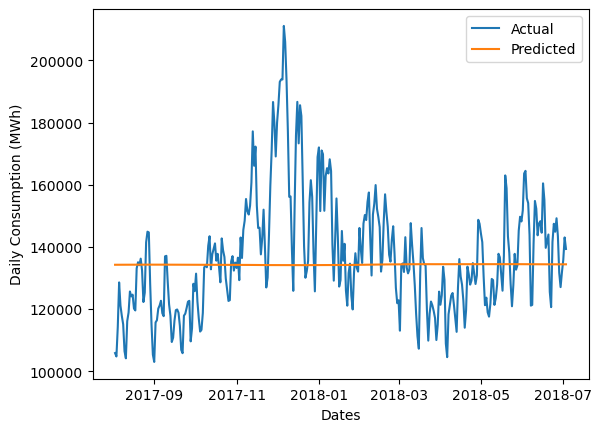

In [120]:
utils.plot_predictions(actuals, predictions, dates=holdout.index[:-30]);

In [121]:
pd.DataFrame(
    arima_performances, index=metrics.keys()).to_csv('results/arima.csv')

## Additional References

1. Choosing `p` and `q`: https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf